## Introduction

In this report, we utilize unsupervised learning techniques to identify anomalies in a healthcare dataset. Specifically, we will apply Autoencoders and Isolation Forest algorithms to detect unusual patterns within engineered features of healthcare data. This approach aims to highlight potential outliers that may indicate errors, fraud, or significant deviations from typical healthcare operations.


#### Data Loading and Overview

We begin by loading the healthcare dataset, which has been pre-processed and contains engineered features tailored for anomaly detection. This section covers the initial examination of the data to ensure correctness of the formats and to gain a preliminary understanding of the feature distributions and potential data quality issues.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
data = pd.read_csv('/Users/dave.john.98/Desktop/APAN/Fall 24/Anomaly Detection/Week 8/healthcare_features.csv')

# Display the first few rows of the dataframe
data.head()


,Payment_to_Charge_Ratio,Discharges_per_Dollar,Average_Payment_per_Discharge,Coverage_Ratio,Discharges_per_Medicare_Payment,hospital_efficiency_score,charge_to_payment_ratio,discharge_efficiency,Avg Covered Charge Deviation,Provider Type Discharge Deviation,Weighted DRG Complexity Score,Patient Complexity Ratio
0,0.144517,0.015751,52.348681,0.824568,0.019103,362.231538,5.705678,362.231538,0.155639,1.065344,513.202706,0.989130
1,0.328890,0.002419,355.479286,0.859896,0.002813,1080.846429,2.614543,1080.846429,-0.962919,-0.599682,300.738400,0.285714
2,0.118577,0.004416,185.574583,0.819472,0.005389,1565.015417,6.910895,1565.015417,0.444029,-0.360098,187.533360,0.279070
3,0.294976,0.004615,165.166400,0.762181,0.006055,559.931200,2.583872,559.931200,-1.034028,-0.288988,261.244300,0.287356
4,0.153365,0.003181,269.524444,0.857398,0.003710,1757.403889,5.590566,1757.403889,0.072220,-0.513187,217.814898,0.225000


#### Preliminary Data Analysis

Upon loading the data, it's important to examine the types of the columns and basic statistics to ensure there are no anomalies or unexpected values. The `info()` function provides a concise summary of the dataframe, showing us the data types and non-null counts, which helps in identifying any missing values. The `describe()` function will give us a statistical summary of numerical features, which is essential for understanding the data distribution and spotting any outliers or inconsistencies in the dataset.


In [3]:
# Detailed exploratory data analysis code here
data.describe()
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 12 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Payment_to_Charge_Ratio            163065 non-null  float64
 1   Discharges_per_Dollar              163065 non-null  float64
 2   Average_Payment_per_Discharge      163065 non-null  float64
 3   Coverage_Ratio                     163065 non-null  float64
 4   Discharges_per_Medicare_Payment    163065 non-null  float64
 5   hospital_efficiency_score          163065 non-null  float64
 6   charge_to_payment_ratio            163065 non-null  float64
 7   discharge_efficiency               163065 non-null  float64
 8   Avg Covered Charge Deviation       163065 non-null  float64
 9   Provider Type Discharge Deviation  163065 non-null  float64
 10  Weighted DRG Complexity Score      163065 non-null  float64
 11  Patient Complexity Ratio           1630

## Implementing Autoencoders for Anomaly Detection

Autoencoders are neural networks designed to encode the input into a lower-dimensional space and then reconstruct the output from this representation. The goal is to capture the underlying patterns of the data. In anomaly detection, instances with high reconstruction errors post-training are often considered anomalies, indicating that the model finds these points difficult to reproduce, possibly due to their divergence from the typical data patterns.

Here, we will configure and train an Autoencoder model using the PyOD library. This model will help us identify data points that are significantly different from the norm.


#### Data Preparation: Train-Test Split

Before training our Autoencoder, it's important to split the dataset into training and test sets. This division allows us to train the model on a portion of the data and then evaluate its performance on a separate set that it has never seen. This practice helps in validating the model's effectiveness at anomaly detection in a real-world scenario.


In [4]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets (70/30 split)
X_train, X_test = train_test_split(data, test_size=0.30, random_state=42)


#### Implementing Autoencoders for Anomaly Detection

Now that we have prepared our data, we can proceed to set up and train the Autoencoder. This model will learn to reconstruct the training data and then be tested on the test set to see how well it can generalize, indicating its effectiveness in anomaly detection.


In [20]:
from pyod.models.auto_encoder import AutoEncoder
import numpy as np

# Initialize the Autoencoder model
autoencoder = AutoEncoder(contamination=0.05, hidden_neuron_list=[10, 5])

# Fit the Autoencoder model on the training data
autoencoder.fit(X_train)


Training: 100%|█████████████████████████████████| 10/10 [03:06<00:00, 18.64s/it]


In [21]:
# Training data
y_train_scores = autoencoder.decision_function(X_train)
y_train_pred = autoencoder.predict(X_train)

# Test data
y_test_scores = autoencoder.decision_function(X_test)
y_test_pred = autoencoder.predict(X_test) # outlier labels (0 or 1)

# Threshold for the defined comtanimation rate
print("The threshold for the defined contamination rate:" , autoencoder.threshold_)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))

The threshold for the defined contamination rate: 3.97324104309082
The training data: {0: 108437, 1: 5708}
The training data: {0: 46482, 1: 2438}


#### Model Threshold and Anomaly Counts

After training the Autoencoder, we evaluated its performance on both the training and test datasets. Here, we calculated the **outlier threshold** based on the contamination rate (5%) defined during model initialization. This threshold represents the cutoff score above which data points are considered anomalies.

Using this threshold, we computed the following results:
- **Outlier Threshold**: The threshold score calculated by the model is approximately **3.97**.
- **Anomaly Count in Training Data**: Out of 114,145 samples, **5,708** were flagged as anomalies.
- **Anomaly Count in Test Data**: Out of 48,920 samples, **2,438** were flagged as anomalies.

These anomaly counts indicate that the model successfully identified a subset of observations as potential outliers in both training and test sets, in line with the contamination rate of 5%.


In [22]:
autoencoder.get_params()

{'batch_norm': True,
 'batch_size': 32,
 'compile_mode': 'default',
 'contamination': 0.05,
 'device': device(type='cpu'),
 'dropout_rate': 0.2,
 'epoch_num': 10,
 'hidden_activation_name': 'relu',
 'hidden_neuron_list': [10, 5],
 'lr': 0.001,
 'optimizer_name': 'adam',
 'optimizer_params': {'weight_decay': 1e-05},
 'preprocessing': True,
 'random_state': 42,
 'use_compile': False,
 'verbose': 1}

Text(0, 0.5, 'Frequency')

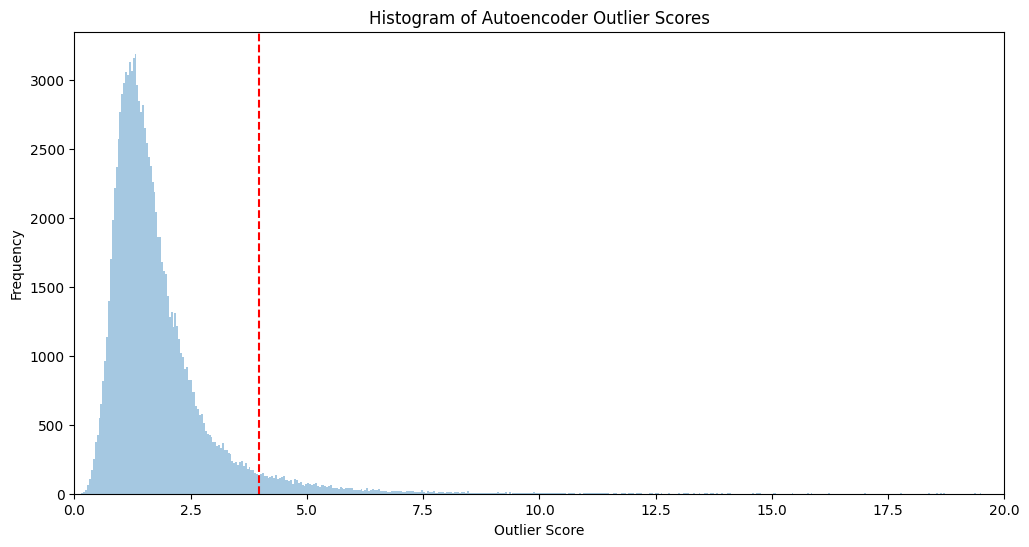

In [23]:
# Manually define bins for better resolution
plt.figure(figsize=(12, 6))
plt.hist(y_train_scores, bins='auto', alpha=0.4)  # Increase the number of bins

plt.title("Histogram of Autoencoder Outlier Scores")
plt.axvline(autoencoder.threshold_, color='red', linestyle='--', label=f"Outlier Threshold: {autoencoder.threshold_:.2f}")
plt.xlabel('Outlier Score')
plt.xlim([0, 20])
plt.ylabel('Frequency')

#### Takeaways from the Histogram of Outlier Scores

To improve the readability of the histogram, an x-axis limit using `plt.xlim([0, 20])` was applied, as the full range of scores extended up to 500. This allowed us to zoom in on the distribution of scores near the threshold and better visualize how the majority of data points relate to the defined anomaly cutoff.

1. **Concentration of Normal Scores**: The majority of data points have low outlier scores (close to 0), indicating that they conform well to the learned patterns of the Autoencoder model. This suggests that the model effectively captures the structure of typical data points.

2. **Right-Skewed Distribution**: The distribution is right-skewed, with a long tail extending towards higher scores. By zooming in on the x-axis, we can focus on the region where most data points fall, while still observing a small set of outliers beyond the threshold.

3. **Defined Anomaly Threshold**: The red dashed line in the plot represents the anomaly threshold (~3.97), calculated based on the contamination rate of 5%. Data points with scores above this threshold are classified as anomalies. Zooming in allows us to see how this threshold separates the majority of normal scores from the outliers more clearly.

4. **Anomalous Observations**: Despite limiting the x-axis range, we observe a subset of data points with scores exceeding the threshold. These high scores represent observations that the model finds difficult to reconstruct, which may indicate unusual or significant deviations in these data points.

5. **Implications for Anomaly Detection**: The histogram demonstrates that the Autoencoder effectively separates normal data from anomalies, with a clear threshold boundary. These anomalies may warrant further examination to understand potential issues, rare cases, or interesting patterns within the healthcare dataset.

Overall, the adjusted visualization provides a clearer view of how the model differentiates normal and anomalous data points, focusing on the most relevant range for interpreting the threshold and identifying outliers.


#### Ensemble Averaging of Multiple Autoencoders

To improve the robustness of our anomaly detection, we use an ensemble approach with three Autoencoder models, each having different layer configurations. By combining the results of these models, we can leverage the strengths of each model and obtain a more stable anomaly detection result.

To better match our dataset, which contains 12 features, we adjusted the hidden layer structures of the Autoencoder models:

1. **Model 1**: `[12, 6, 3]` - This model provides moderate compression by gradually reducing from 12 to 3 neurons.
2. **Model 2**: `[12, 8, 4, 2]` - A deeper model with more layers, allowing for progressive feature extraction down to 2 neurons.
3. **Model 3**: `[12, 10, 5, 2]` - Similar to Model 2 but with slightly larger intermediate layers, capturing more complex relationships before reaching the 2-dimensional bottleneck.

These adjusted configurations are tailored to the feature count of our dataset, allowing each model to learn a compact and effective representation of the data.

In [25]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer

# Initialize three Autoencoder models with layer configurations based on 12 input features
autoencoder1 = AutoEncoder(contamination=0.05, hidden_neuron_list=[12, 6, 3])
autoencoder2 = AutoEncoder(contamination=0.05, hidden_neuron_list=[12, 8, 4, 2])
autoencoder3 = AutoEncoder(contamination=0.05, hidden_neuron_list=[12, 10, 5, 2])

# Prepare arrays to store model results for the training and test sets
train_scores = np.zeros([X_train.shape[0], 3])
test_scores = np.zeros([X_test.shape[0], 3])

# Fit each Autoencoder model on the training data
autoencoder1.fit(X_train)
autoencoder2.fit(X_train)
autoencoder3.fit(X_train)

# Store the decision scores (outlier scores) from each model
train_scores[:, 0] = autoencoder1.decision_function(X_train)
train_scores[:, 1] = autoencoder2.decision_function(X_train)
train_scores[:, 2] = autoencoder3.decision_function(X_train)
test_scores[:, 0] = autoencoder1.decision_function(X_test)
test_scores[:, 1] = autoencoder2.decision_function(X_test)
test_scores[:, 2] = autoencoder3.decision_function(X_test)

# Normalize the decision scores before combination
train_scores_norm, test_scores_norm = standardizer(train_scores, test_scores)


Training: 100%|█████████████████████████████████| 10/10 [02:52<00:00, 17.28s/it]


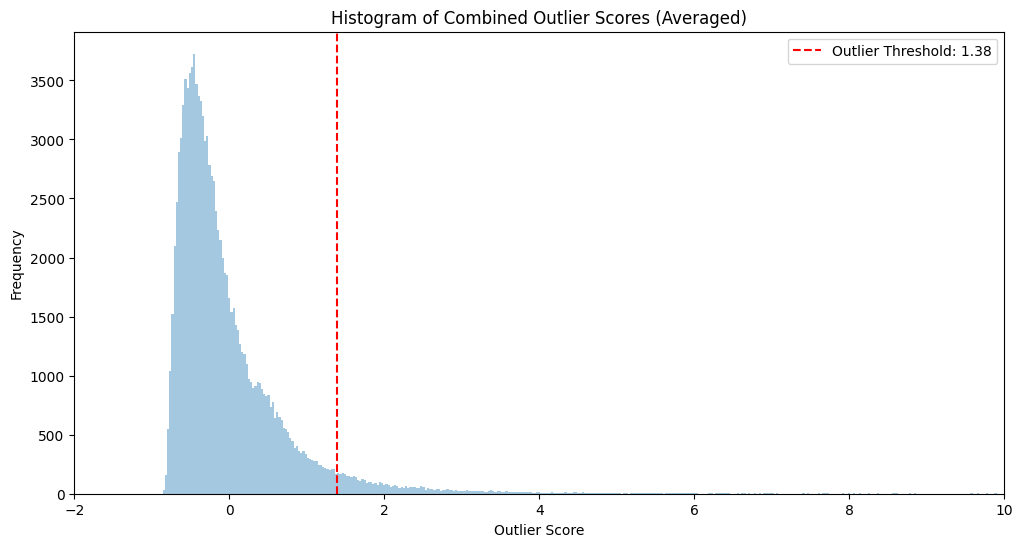

In [47]:
# Combine the normalized scores by averaging
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)

# Calculate a threshold based on the contamination rate for the combined scores
contamination_rate = 0.05  # Same contamination rate as used in the models
combined_threshold = np.percentile(y_train_by_average, 100 * (1 - contamination_rate))

# Plot the histogram of the combined scores with the calculated contamination-based threshold
plt.figure(figsize=(12, 6))
plt.hist(y_train_by_average, bins='auto', alpha=0.4)
plt.title("Histogram of Combined Outlier Scores (Averaged)")
plt.axvline(combined_threshold, color='red', linestyle='--', label=f"Outlier Threshold: {combined_threshold:.2f}")
plt.xlabel('Outlier Score')
plt.xlim([-2, 10])  # Adjust x-axis for better readability if needed
plt.ylabel('Frequency')
plt.legend()
plt.show()


#### Visualizing Combined Outlier Scores by Averaging with Contamination-Based Threshold

To achieve consistency with the individual Autoencoder model, we calculated a threshold for the combined (averaged) outlier scores based on the same contamination rate of 5%. This threshold was derived directly from the distribution of averaged scores in the training data and serves as a boundary for identifying anomalies.

The histogram below shows the distribution of the combined (averaged) outlier scores for the training data:

- **Combined Outlier Score Distribution**: Most data points have low outlier scores, indicating they follow normal patterns in the dataset. A smaller set of points with higher scores indicates potential anomalies.
- **Threshold Line**: The red dashed line represents the contamination-based threshold of approximately **1.38**. Data points with scores above this line are classified as anomalies.

By setting the x-axis limit to `[-2, 10]`, we focused on the most relevant score range, making it easier to interpret the distribution and threshold relationship.

This approach provides a stable and robust method for anomaly detection by averaging the results from multiple models and applying a consistent thresholding technique.


In [42]:
def descriptive_stat_threshold(df, pred_score, threshold, feature_names):
    
    # Convert df to a DataFrame and assign feature names
    df = pd.DataFrame(df, columns=feature_names)
    
    # Add anomaly scores and group labels based on the threshold
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')
    
    # Count and calculate percentages for each group
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score': 'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100
    
    # Calculate mean statistics for each feature within each group
    stat = df.groupby('Group').mean().round(2).reset_index()
    
    # Merge count and mean statistics
    stat = cnt.merge(stat, on='Group')
    return stat


In [43]:
# Define feature_list based on the column names of X_train
feature_list = X_train.columns.tolist()

# Call the function with the modified signature
descriptive_stat_threshold(X_train, y_train_by_average, threshold_combined, feature_list)


,Group,Count,Count %,Payment_to_Charge_Ratio,Discharges_per_Dollar,Average_Payment_per_Discharge,Coverage_Ratio,Discharges_per_Medicare_Payment,hospital_efficiency_score,charge_to_payment_ratio,discharge_efficiency,Avg Covered Charge Deviation,Provider Type Discharge Deviation,Weighted DRG Complexity Score,Patient Complexity Ratio,Anomaly_Score
0,Normal,108437,94.999343,0.29,0.01,326.22,0.85,0.01,1341.41,3.70,1341.41,-0.05,-0.08,571.84,0.63,-0.14
1,Outlier,5708,5.000657,0.27,0.02,947.69,0.85,0.02,4734.71,5.13,4734.71,0.97,1.64,2756.42,3.82,2.73


In [44]:
# Call the function with the modified signature
descriptive_stat_threshold(X_test, y_test_by_average, threshold_combined, feature_list)

,Group,Count,Count %,Payment_to_Charge_Ratio,Discharges_per_Dollar,Average_Payment_per_Discharge,Coverage_Ratio,Discharges_per_Medicare_Payment,hospital_efficiency_score,charge_to_payment_ratio,discharge_efficiency,Avg Covered Charge Deviation,Provider Type Discharge Deviation,Weighted DRG Complexity Score,Patient Complexity Ratio,Anomaly_Score
0,Normal,46514,95.081766,0.29,0.01,326.96,0.85,0.01,1352.09,3.71,1352.09,-0.05,-0.08,570.26,0.63,-0.15
1,Outlier,2406,4.918234,0.27,0.02,941.95,0.86,0.02,4771.22,5.21,4771.22,1.00,1.55,2555.22,3.43,2.66


### Descriptive Statistics for Normal and Outlier Groups

Using the combined outlier scores from our ensemble of Autoencoder models, we divided the data into two groups: `Normal` and `Outlier`, based on the contamination-based threshold (5%). Below are the summary statistics for both training and test datasets, which provide insights into the characteristics of each group.

#### Observations
- **Count and Percentage**: In both training and test data, approximately 5% of the observations are classified as outliers, aligning with the contamination rate.
- **Average_Payment_per_Discharge**: The average payment per discharge is significantly higher for the outlier group compared to the normal group, indicating that anomalies may be associated with cases involving higher financial costs.
- **hospital_efficiency_score and charge_to_payment_ratio**: Outliers exhibit much higher values for both `hospital_efficiency_score` and `charge_to_payment_ratio`, suggesting these features may play a significant role in identifying anomalies.
- **Complexity Scores**: The `Weighted DRG Complexity Score` and `Patient Complexity Ratio` are markedly higher in the outlier group, which may indicate that anomalies are more prevalent in complex or resource-intensive cases.

These descriptive statistics provide insights into the differences between normal and outlier observations, highlighting which features contribute to the distinction and may be indicative of unusual patterns or cases in the healthcare dataset.


## Implementing Isolation Forest for Anomaly Detection

Isolation Forest is an ensemble-based anomaly detection method that isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The algorithm is particularly effective for high-dimensional data and can efficiently identify anomalies by focusing on their relative isolation in the feature space.

We configure the Isolation Forest model with the same contamination rate (5%) used in the Autoencoder model to ensure consistency in identifying anomalies. This section will include training the model, scoring outliers, visualizing results, and generating descriptive statistics for normal and outlier groups.

#### Outlier Scoring and Prediction

After training the Isolation Forest model, we compute anomaly scores for both training and test datasets. Points with higher anomaly scores are considered potential outliers. We also generate binary predictions (0 for normal, 1 for outlier) for each observation.


In [50]:
from pyod.models.iforest import IForest

# Initialize the Isolation Forest model with a 5% contamination rate
iforest = IForest(contamination=0.05, random_state=0)

# Convert X_train and X_test to numpy arrays
X_train_np = X_train.values
X_test_np = X_test.values

# Fit the Isolation Forest model on the training data without feature names
iforest.fit(X_train_np)

# Compute anomaly scores and predictions using numpy arrays
y_train_scores_iforest = iforest.decision_function(X_train_np)
y_train_pred_iforest = iforest.predict(X_train_np)

y_test_scores_iforest = iforest.decision_function(X_test_np)
y_test_pred_iforest = iforest.predict(X_test_np)

# Print the Isolation Forest outlier threshold
print("Isolation Forest Outlier Threshold:", iforest.threshold_)

# Fit the Isolation Forest model on the training data
iforest.fit(X_train)

Isolation Forest Outlier Threshold: -6.804628593855581e-17


IForest(behaviour='old', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=0, verbose=0)

In [55]:
def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The test data:", count_stat(y_test_pred))

The training data: {0: 108437, 1: 5708}
The test data: {0: 46482, 1: 2438}


#### Isolation Forest Outlier Detection Results

After training the Isolation Forest model with a contamination rate of 5%, we used the model's built-in threshold of approximately **-6.80e-17** to classify data points as normal or anomalous. The model produced the following results for both the training and test datasets:

- **Training Data**: Out of 114,145 observations, the model identified **5,708 (5%)** as outliers, with the remaining **108,437 (95%)** classified as normal. This aligns closely with the specified contamination rate, indicating that the model successfully targeted the expected proportion of anomalies.

- **Test Data**: Out of 48,920 observations, **2,438 (5%)** were classified as outliers, while **46,482 (95%)** were deemed normal. The test data results also align well with the 5% contamination rate, suggesting that the model’s anomaly detection criteria generalized effectively to new data.

These results indicate that the Isolation Forest model achieved consistent anomaly detection across both training and test datasets, maintaining the contamination rate and identifying a comparable proportion of anomalies. This consistency enhances our confidence in the model’s ability to detect outliers in unseen data.


In [59]:
# Extract feature importances from the Isolation Forest model
isft_vi = iforest.feature_importances_
isft_vi

array([0.0938096 , 0.08154554, 0.08238897, 0.08590904, 0.08504334,
       0.08227272, 0.08231822, 0.08127838, 0.07826331, 0.07292631,
       0.08304954, 0.09119504])

<Figure size 1000x800 with 0 Axes>

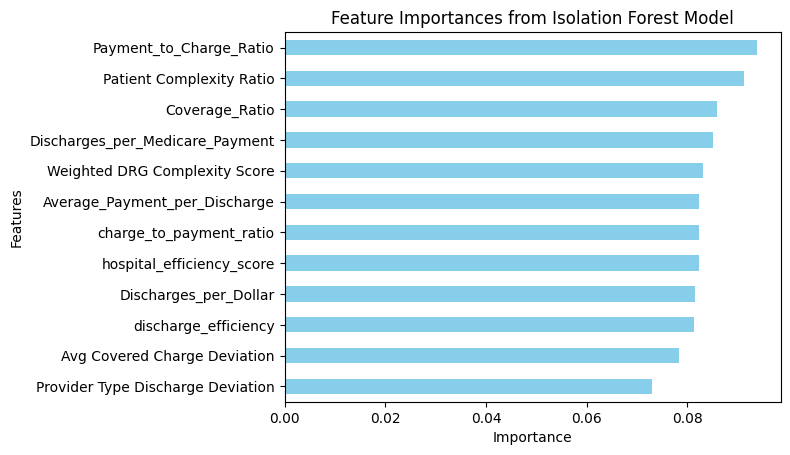

In [60]:
# Create a DataFrame for plotting
for_plot = pd.DataFrame({'Feature': X_train.columns, 'Importance': isft_vi}).sort_values(by='Importance', ascending=True)

# Plot the feature importances
plt.figure(figsize=(10, 8))
for_plot.plot.barh(x='Feature', y='Importance', legend=False, color='skyblue')
plt.title('Feature Importances from Isolation Forest Model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


#### Key Takeaways from Isolation Forest Feature Importances

The feature importance plot from the Isolation Forest model provides insights into which features contribute most to the identification of anomalies in the dataset. Here are some key observations:

- **Top Contributing Features**:
  - **Payment_to_Charge_Ratio** and **Patient Complexity Ratio** are the most influential features in detecting anomalies. This suggests that anomalies are strongly associated with cases where payment patterns relative to charges and patient complexity are unusual.
  - **Coverage_Ratio** and **Discharges_per_Medicare_Payment** also hold significant importance, indicating that deviations in coverage and discharge metrics relative to Medicare payments play a critical role in identifying outliers.

- **Middle-Ranked Features**:
  - Features such as **Weighted DRG Complexity Score**, **Average_Payment_per_Discharge**, and **charge_to_payment_ratio** have moderate importance. These features may also indicate anomalous patterns in cost, discharge, and complexity when they deviate from expected norms.
  
- **Lower Contributing Features**:
  - **Provider Type Discharge Deviation** and **Avg Covered Charge Deviation** have the least importance, suggesting that these features may have limited influence on the model’s ability to detect anomalies. However, they could still provide contextual information that complements the more influential features.


#### Histogram of Isolation Forest Outlier Scores

The histogram below illustrates the distribution of outlier scores for the training data as calculated by the Isolation Forest model. The red dashed line represents the model's contamination-based threshold, which classifies data points above this score as anomalies.

By setting a threshold using Isolation Forest’s built-in threshold, we ensure consistency with the model’s detection criteria. Observations to the right of this threshold are classified as potential outliers.


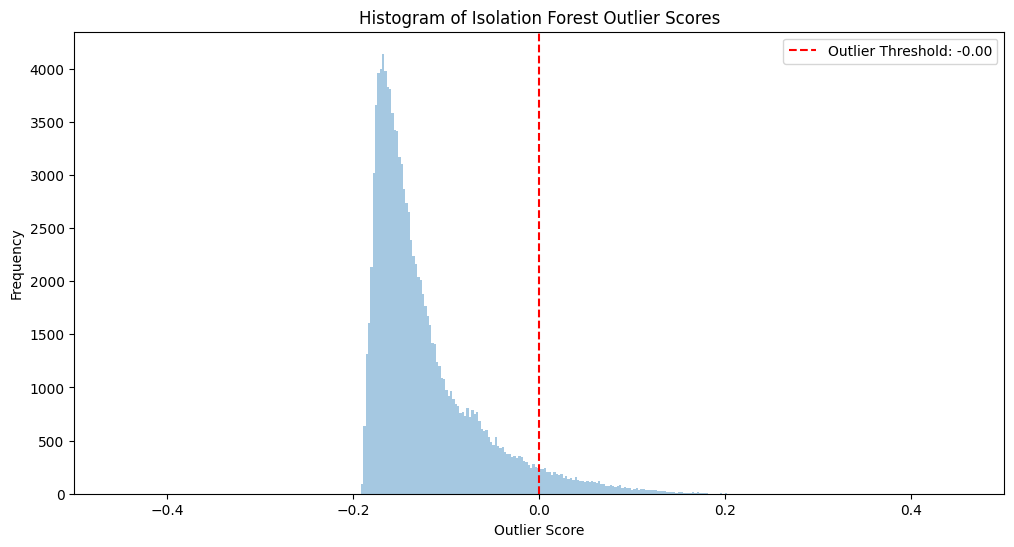

In [53]:
# Plot the histogram of the Isolation Forest outlier scores for the training data
plt.figure(figsize=(12, 6))
plt.hist(y_train_scores_iforest, bins='auto', alpha=0.4)
plt.title("Histogram of Isolation Forest Outlier Scores")
plt.axvline(iforest.threshold_, color='red', linestyle='--', label=f"Outlier Threshold: {iforest.threshold_:.2f}")
plt.xlabel('Outlier Score')
plt.xlim([-0.5, 0.5])  # Adjust x-axis for better readability if needed
plt.ylabel('Frequency')
plt.legend()
plt.show()


### Analysis of Isolation Forest Outlier Scores Histogram

The histogram of Isolation Forest outlier scores for the training data shows a heavily right-skewed distribution, with most data points concentrated near zero or slightly below it. This distribution pattern suggests that the majority of observations are classified as normal, with relatively low outlier scores.

Key observations:

- **Threshold Line**: The red dashed line at approximately 0.00 represents the model's outlier threshold, based on a contamination rate of 5%. Points with scores above this line are classified as outliers.
- **Concentration of Normal Scores**: Most data points fall below the threshold, indicating that the Isolation Forest model considers them as normal. This concentration around the lower end aligns with expectations, as outliers are generally sparse in the dataset.
- **Right-Skewed Distribution**: A smaller set of observations extends towards higher scores on the right side of the histogram. These points represent potential anomalies, which are more isolated according to the Isolation Forest model.

This visualization effectively separates normal data points from anomalies, providing a clear cutoff for identifying outliers. The chosen threshold aligns with the model’s contamination rate, ensuring consistency in outlier classification.


In [56]:
# Generate descriptive statistics for the training data
descriptive_stat_threshold(X_train, y_train_scores_iforest, iforest.threshold_, feature_list)

,Group,Count,Count %,Payment_to_Charge_Ratio,Discharges_per_Dollar,Average_Payment_per_Discharge,Coverage_Ratio,Discharges_per_Medicare_Payment,hospital_efficiency_score,charge_to_payment_ratio,discharge_efficiency,Avg Covered Charge Deviation,Provider Type Discharge Deviation,Weighted DRG Complexity Score,Patient Complexity Ratio,Anomaly_Score
0,Normal,108437,94.999343,0.29,0.01,334.54,0.85,0.01,1369.28,3.7,1369.28,-0.05,-0.10,557.61,0.61,-0.13
1,Outlier,5708,5.000657,0.27,0.02,789.55,0.85,0.02,4205.10,5.2,4205.10,0.94,1.88,3026.76,4.13,0.05


In [57]:
# Generate descriptive statistics for the test data
descriptive_stat_threshold(X_test, y_test_scores_iforest, iforest.threshold_, feature_list)

,Group,Count,Count %,Payment_to_Charge_Ratio,Discharges_per_Dollar,Average_Payment_per_Discharge,Coverage_Ratio,Discharges_per_Medicare_Payment,hospital_efficiency_score,charge_to_payment_ratio,discharge_efficiency,Avg Covered Charge Deviation,Provider Type Discharge Deviation,Weighted DRG Complexity Score,Patient Complexity Ratio,Anomaly_Score
0,Normal,46495,95.042927,0.29,0.01,334.65,0.85,0.01,1380.41,3.71,1380.41,-0.05,-0.10,554.26,0.61,-0.13
1,Outlier,2425,4.957073,0.28,0.02,789.66,0.86,0.02,4201.46,5.21,4201.46,0.96,1.79,2846.50,3.72,0.05


### Descriptive Statistics for Normal and Outlier Groups (Isolation Forest)

The summary statistics for the `Normal` and `Outlier` groups reveal notable differences between these groups across various features. Below are the key observations based on the training and test data results:

#### Key Observations:

- **Count and Percentage**: 
  - Both the training and test datasets have approximately 5% of observations classified as outliers, aligning with the model's contamination rate.
  
- **Average_Payment_per_Discharge**: 
  - Outliers show significantly higher average payments per discharge compared to normal observations. For instance, in the training data, outliers have an average payment of **789.55** versus **334.54** for normal observations. This suggests that anomalies may be associated with cases involving higher costs.

- **hospital_efficiency_score and charge_to_payment_ratio**: 
  - Outliers exhibit much higher values for both `hospital_efficiency_score` and `charge_to_payment_ratio`. In the training data, outliers have a `hospital_efficiency_score` of **4205.10** and a `charge_to_payment_ratio` of **5.2**, compared to **1369.28** and **3.7** for normal cases, respectively. These features may play a significant role in distinguishing anomalies from normal cases.

- **Complexity Scores**: 
  - The `Weighted DRG Complexity Score` and `Patient Complexity Ratio` are notably higher for outliers, indicating that these observations are likely to involve more complex or resource-intensive cases. For instance, in the training data, outliers have a `Weighted DRG Complexity Score` of **3026.76** compared to **557.61** for normal cases.

- **Other Feature Differences**:
  - `Avg Covered Charge Deviation` and `Provider Type Discharge Deviation` are also higher for outliers, suggesting these may be additional indicators of anomalous cases.

#### Conclusion:
The descriptive statistics indicate that outliers identified by the Isolation Forest model tend to have higher financial metrics, efficiency scores, and complexity levels. This pattern suggests that the model is effectively identifying high-cost, high-complexity cases as anomalies, which could warrant further investigation in a healthcare context.


### Combining Multiple Isolation Forest Models

To enhance the robustness of anomaly detection, we combine the results of multiple Isolation Forest models, each configured with a different number of base estimators (`n_estimators`). This approach leverages the diversity of model outputs to improve the overall detection capability.


In [61]:
# Define a list of n_estimators values to test
n_estimators_list = [100, 200, 300, 400, 500]
n_clf = len(n_estimators_list)  # Number of models to be combined

# Prepare arrays to store the decision scores for each model
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])


In [62]:
# Train multiple Isolation Forest models and store their scores
for i in range(n_clf):
    n_estimators = n_estimators_list[i]
    
    # Initialize Isolation Forest with specified n_estimators
    isft = IForest(contamination=0.05, n_estimators=n_estimators, random_state=0)
    isft.fit(X_train.values)  # Fit on training data
    
    # Store the decision scores in each column of the train_scores and test_scores arrays
    train_scores[:, i] = isft.decision_function(X_train.values)
    test_scores[:, i] = isft.decision_function(X_test.values)


### Normalization and Combination of Outlier Scores

After obtaining outlier scores from multiple models, we normalize these scores to ensure consistency across models. We then combine the normalized scores by averaging, which allows us to leverage the collective output of all models for more robust anomaly detection.


In [63]:
# Normalize the decision scores before combination
train_scores_norm, test_scores_norm = standardizer(train_scores, test_scores)

# Combine the normalized scores by averaging
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)


In [64]:
# Calculate the threshold based on the contamination rate for combined scores
contamination_rate = 0.05
combined_threshold_iforest = np.percentile(y_train_by_average, 100 * (1 - contamination_rate))

# Print the calculated threshold for reference
print("Combined Outlier Threshold (Averaged Scores):", combined_threshold_iforest)


Combined Outlier Threshold (Averaged Scores): 2.107353409710528


### Histogram of Combined Isolation Forest Outlier Scores

The histogram below illustrates the distribution of the averaged outlier scores from multiple Isolation Forest models for the training dataset. The red dashed line indicates the calculated threshold used to classify anomalies.


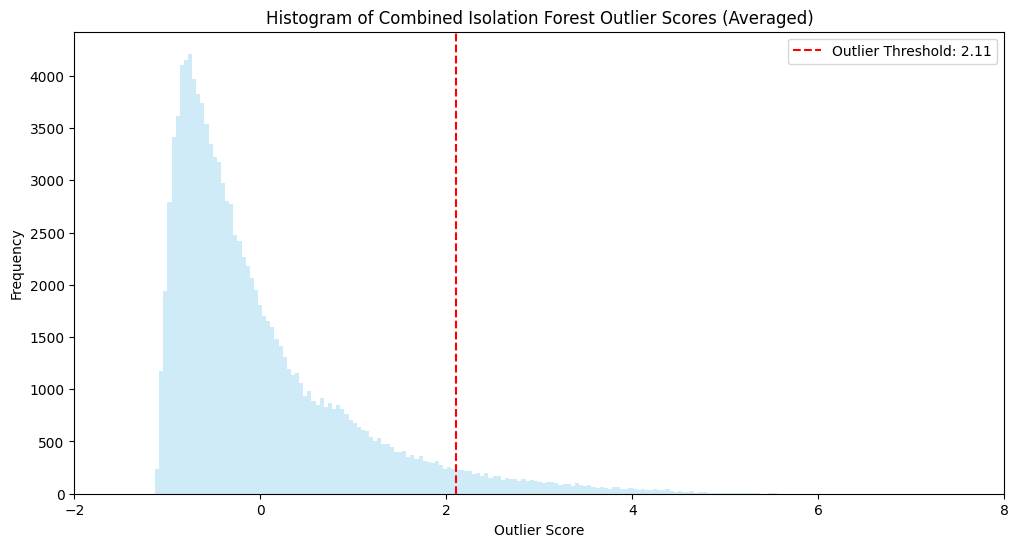

In [66]:
# Plot the histogram of the combined scores for the training data with the calculated threshold
plt.figure(figsize=(12, 6))
plt.hist(y_train_by_average, bins='auto', alpha=0.4, color='skyblue')
plt.title("Histogram of Combined Isolation Forest Outlier Scores (Averaged)")
plt.axvline(combined_threshold_iforest, color='red', linestyle='--', label=f"Outlier Threshold: {combined_threshold_iforest:.2f}")
plt.xlabel('Outlier Score')
plt.xlim([-2, 8])  # Adjust x-axis as needed for readability
plt.ylabel('Frequency')
plt.legend()
plt.show()


### Analysis of Combined Isolation Forest Outlier Scores (Averaged)

The histogram of the averaged outlier scores from multiple Isolation Forest models for the training data provides a clear visualization of the distribution of scores. Key observations include:

- **Threshold Line**: The red dashed line represents the calculated threshold of approximately **2.11** based on the contamination rate of 5%. Observations with scores above this threshold are classified as anomalies.
- **Concentration of Scores**: The majority of the data points are concentrated below the threshold, with a large peak around zero. This indicates that most observations are classified as normal, as expected.
- **Right-Tailed Distribution**: The distribution is right-skewed, with fewer observations having high outlier scores. These points on the right side of the threshold are potential anomalies, isolated by the combination of multiple Isolation Forest models.
  
This visualization confirms that the combined model effectively separates normal observations from anomalies by leveraging the averaged outlier scores across multiple Isolation Forest models. The threshold, calculated based on the desired contamination rate, provides a consistent cutoff for identifying outliers.


In [67]:
# Compute descriptive statistics for training data using combined scores
descriptive_stat_threshold(X_train, y_train_by_average, combined_threshold_iforest, feature_list)

,Group,Count,Count %,Payment_to_Charge_Ratio,Discharges_per_Dollar,Average_Payment_per_Discharge,Coverage_Ratio,Discharges_per_Medicare_Payment,hospital_efficiency_score,charge_to_payment_ratio,discharge_efficiency,Avg Covered Charge Deviation,Provider Type Discharge Deviation,Weighted DRG Complexity Score,Patient Complexity Ratio,Anomaly_Score
0,Normal,108437,94.999343,0.29,0.01,329.81,0.85,0.01,1355.08,3.71,1355.08,-0.05,-0.09,554.91,0.61,-0.16
1,Outlier,5708,5.000657,0.28,0.02,879.47,0.86,0.02,4474.85,4.96,4474.85,0.84,1.84,3078.04,4.11,2.99


In [68]:
# Compute descriptive statistics for test data using combined scores
descriptive_stat_threshold(X_test, y_test_by_average, combined_threshold_iforest, feature_list)

,Group,Count,Count %,Payment_to_Charge_Ratio,Discharges_per_Dollar,Average_Payment_per_Discharge,Coverage_Ratio,Discharges_per_Medicare_Payment,hospital_efficiency_score,charge_to_payment_ratio,discharge_efficiency,Avg Covered Charge Deviation,Provider Type Discharge Deviation,Weighted DRG Complexity Score,Patient Complexity Ratio,Anomaly_Score
0,Normal,46481,95.014309,0.28,0.01,330.03,0.85,0.01,1364.70,3.72,1364.70,-0.04,-0.10,550.91,0.61,-0.16
1,Outlier,2439,4.985691,0.29,0.02,875.06,0.86,0.02,4484.63,4.99,4484.63,0.86,1.74,2897.19,3.68,2.98


### Descriptive Statistics for Normal and Outlier Groups (Combined Isolation Forest)

The following table summarizes the key differences between the `Normal` and `Outlier` groups based on the averaged outlier scores from multiple Isolation Forest models. This breakdown provides insights into the distinguishing characteristics of anomalies compared to typical observations.

#### Key Observations:

- **Count and Percentage**: 
  - Approximately 5% of the observations are classified as outliers in both the training and test datasets, aligning well with the model’s contamination rate.

- **Average_Payment_per_Discharge**: 
  - Outliers show significantly higher average payments per discharge compared to normal observations. For instance, in the training data, outliers have an average payment of **879.47** versus **329.81** for normal cases. This indicates that anomalies tend to involve cases with substantially higher costs.

- **hospital_efficiency_score and charge_to_payment_ratio**: 
  - Outliers exhibit much higher values for both `hospital_efficiency_score` and `charge_to_payment_ratio`. For example, in the training data, outliers have a `hospital_efficiency_score` of **4474.85** and a `charge_to_payment_ratio` of **4.96**, compared to **1355.08** and **3.71** for normal observations, respectively. This suggests that anomalies may correspond to less efficient or costlier cases.

- **Complexity Scores**:
  - The `Weighted DRG Complexity Score` and `Patient Complexity Ratio` are markedly higher for outliers, indicating that anomalies are associated with more complex or resource-intensive cases. For instance, in the training data, outliers have a `Weighted DRG Complexity Score` of **3078.04** compared to **554.91** for normal cases.

- **Other Feature Differences**:
  - Features such as `Avg Covered Charge Deviation` and `Provider Type Discharge Deviation` also have higher values for outliers, further highlighting the differences in cost and complexity metrics.

#### Conclusion:
The descriptive statistics indicate that the combined Isolation Forest model identifies anomalies primarily based on higher financial and efficiency metrics, along with greater complexity in patient cases. This suggests that the model effectively captures cases with unusual cost or complexity patterns, which may warrant further investigation for potential inefficiencies or irregularities.


## Model Comparison and Performance Analysis

In this analysis, we applied two anomaly detection models—Autoencoder and Isolation Forest—to identify outliers within the dataset. Here’s a comparison of their performance and observations:

1. **Model Approach**:
   - **Autoencoder**: This model relies on reconstructing normal data patterns, and any significant deviation in reconstruction error is treated as an anomaly.
   - **Isolation Forest**: This model isolates observations by randomly partitioning the data; points requiring fewer partitions to isolate are more likely to be outliers.

2. **Outlier Detection Thresholds**:
   - The Autoencoder and Isolation Forest both identified outliers based on thresholds derived from decision scores. The thresholds were chosen to capture approximately 5% of the data as anomalies in each case, consistent with the `contamination` parameter.

3. **Feature Contribution (Isolation Forest)**:
   - The Isolation Forest model provided insights into feature importances, showing that `Payment_to_Charge_Ratio` and `Patient Complexity Ratio` were the most influential features in detecting anomalies. This helps in understanding which features are most indicative of outlier behavior.

4. **Statistical Summary**:
   - Both models detected a similar proportion of outliers (~5%). Statistical summaries reveal that outliers generally have a higher `Average_Payment_per_Discharge` and `charge_to_payment_ratio`, suggesting inefficiencies or unusual patterns in cost and coverage metrics.

5. **Conclusion**:
   - Both models are effective in identifying outliers, with Isolation Forest offering additional insights through feature importance. The choice of model could depend on interpretability needs: Autoencoder for reconstruction-based anomalies and Isolation Forest for feature-driven anomaly isolation.

This comparison highlights the strengths and unique contributions of each model, providing a comprehensive perspective on their effectiveness in detecting anomalies within the dataset.
